In [1]:
import numpy as np
import glob
import os
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from utils import get_sorted_files, show_rgbd, show_pred_gt, normal


In [2]:
def abs_rel_error(img1, img2):
  """
  Calculates the absolute relative error between two images.

  Args:
    img1: The first image as a NumPy array.
    img2: The second image as a NumPy array.

  Returns:
    The absolute relative error between the two images.
  """

  assert img1.shape == img2.shape, "Images must have the same shape"

  diff = np.abs(img1 - img2)
  rel_diff = diff / (img2 + 1e-8)  # Add a small value to avoid division by zero
  abs_rel = np.mean(rel_diff)
  return abs_rel

def cap_values(image, lower_percentile=0, upper_percentile=99):
    # Calculate the lower and upper percentile values
    lower_value = np.percentile(image, lower_percentile)
    upper_value = np.percentile(image, upper_percentile)

    # Cap the values
    capped_image = np.clip(image, lower_value, upper_value)

    return capped_image

def plot_histogram(image, bins=256):
    # Flatten the image to a 1D array
    flattened_image = image.flatten()
    
    # Calculate the minimum and maximum values of the image
    min_val = np.min(flattened_image)
    max_val = np.max(flattened_image)
    
    # Plot the histogram
    plt.hist(flattened_image, bins=bins, range=(min_val, max_val), color='blue', alpha=0.7)
    plt.title('Histogram')
    plt.xlabel('Pixel Values')
    plt.ylabel('Frequency')
    plt.show()

def normalize_depth(depth):
   maxd = depth.max()
   mind = depth.min()

   return (depth - mind)/(maxd - mind)

In [3]:
import numpy as np
array = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9])
mask = np.array([0, 1, 0, 1, 0, 1, 0, 1, 0])
bool_mask = np.array([False, True, False, True, False, True, False, True, False])
print(array[mask.astype(bool)])

[2 4 6 8]


## affine invariant alignment

In [4]:
diode_path = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/"
diode_indoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/indoors/"
diode_outdoor = "/home/gustavo/workstation/depth_estimation/data/datasets_quali/DIODE/val/outdoor/"
diode_indoor_preds = "/home/gustavo/workstation/depth_estimation/data/outputs/DIODE-Anythingv2/npy/indoors/"

filenames_img = get_sorted_files(diode_indoor, ".png")
filenames_depth = get_sorted_files(diode_path, "_depth.npy")
filenames_mask = get_sorted_files(diode_path, "_depth_mask.npy")
filenames_preds_indoor = get_sorted_files(diode_indoor_preds, ".npy")


In [66]:
index = 90
pred_diode = np.load(filenames_preds_indoor[index])
groundtruth = np.load(filenames_depth[index])
rgb = np.array(Image.open(filenames_img[index]))
H,W = groundtruth.shape[0], groundtruth.shape[1]
mask = np.load(filenames_mask[index])
mask = mask.reshape((H, W, 1))

In [67]:
groundtruth_capped_upper = cap_values(groundtruth, 0, 99)
groundtruth_masked = groundtruth*mask
mask_bool = (groundtruth_masked == 0)
groundtruth_masked[mask_bool] = np.inf
disparity_masked = 1/groundtruth_masked

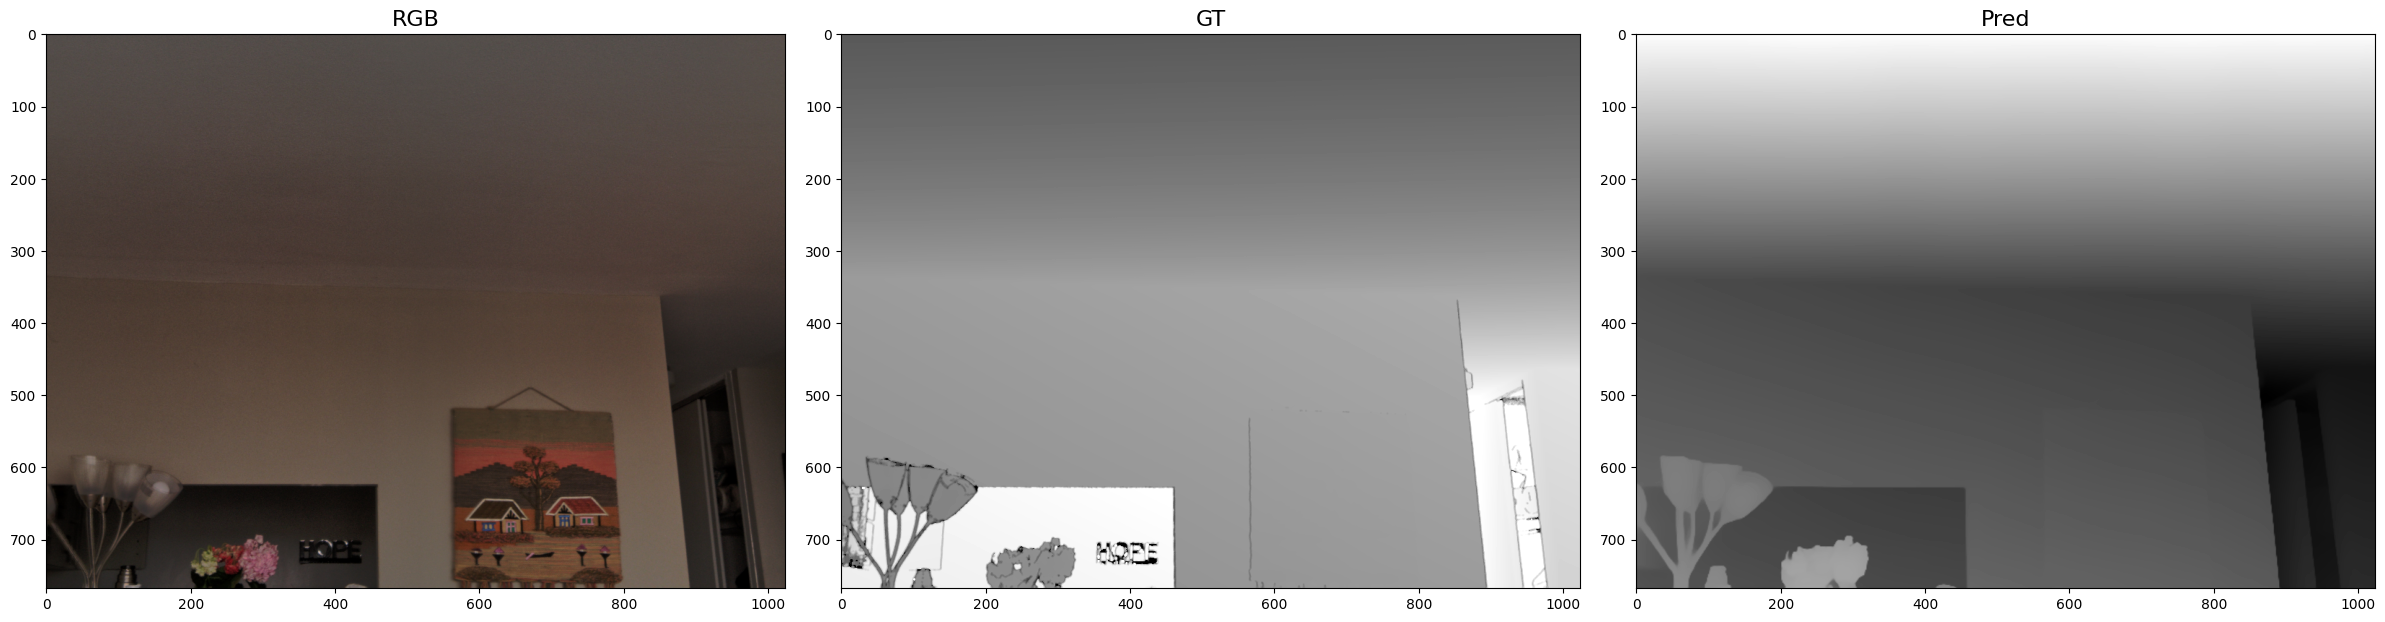

---- Depth Report ----

Unique values: [0.         0.02002219 0.02002322 ... 5.773      5.7730155  5.7730193 ]
how many uniques: 714065
Max: 5.773019313812256
Min: 0.0
shape: (768, 1024, 1)
Has nan: False
Dtype: float32
---- Depth Report ----

Unique values: [2.4235721e-01 2.4319872e-01 3.1924933e-01 ... 5.0577991e+02 5.0578568e+02
 5.0578595e+02]
how many uniques: 764481
Max: 505.78594970703125
Min: 0.24235720932483673
shape: (768, 1024)
Has nan: False
Dtype: float32


In [150]:
show_pred_gt(rgb, groundtruth_capped_upper ,pred_diode)

In [143]:
flat_disparity_gt = disparity_masked.flatten()
flat_mask = mask.astype(bool).flatten()
flat_disparity_gt_masked = flat_disparity_gt[flat_mask] #ESTE AQUI É O GT FLAT 

In [145]:
flat_pred = pred_diode.flatten()
flat_pred_masked = flat_pred[flat_mask] # ESTE AQUI É O PRED FLAT

In [147]:
flat_pred_masked.shape

(777006,)

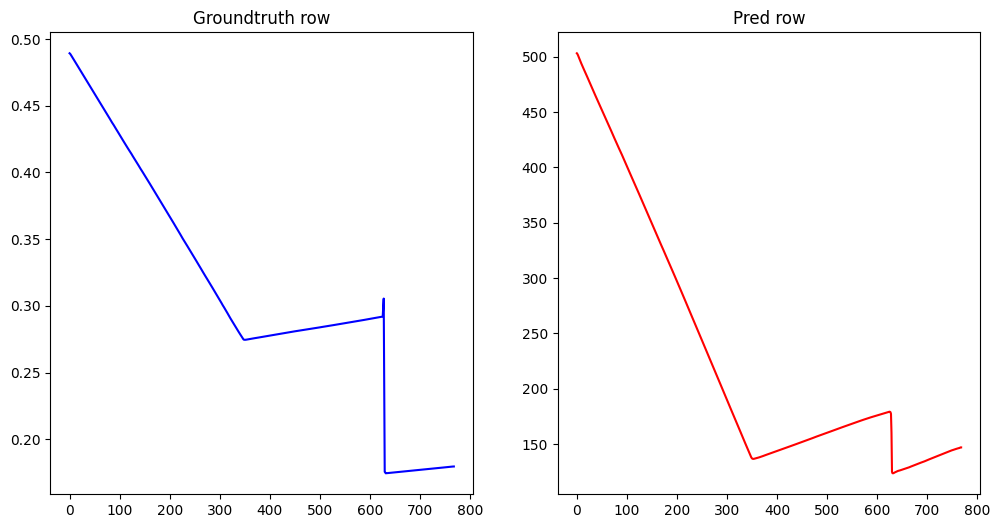

In [129]:
row_index = round(W*(1/3))
disp_row = disparity_masked[:, row_index]
disp_row = disp_row.reshape(H)
pred_row = pred_diode[:, row_index]
pred_row= pred_row.reshape(H)
x = np.linspace(0, H, H)

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot( x, disp_row, 'b')
plt.title("Groundtruth row")
plt.subplot(1,2,2)
plt.plot(x, pred_row, 'r')
plt.title("Pred row")
plt.show()

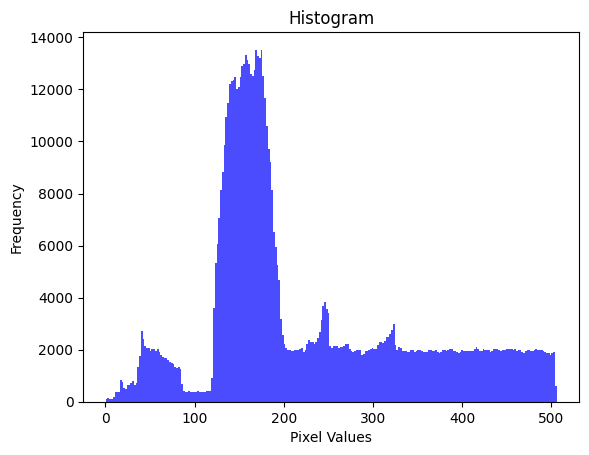

In [84]:
plot_histogram(pred_diode)

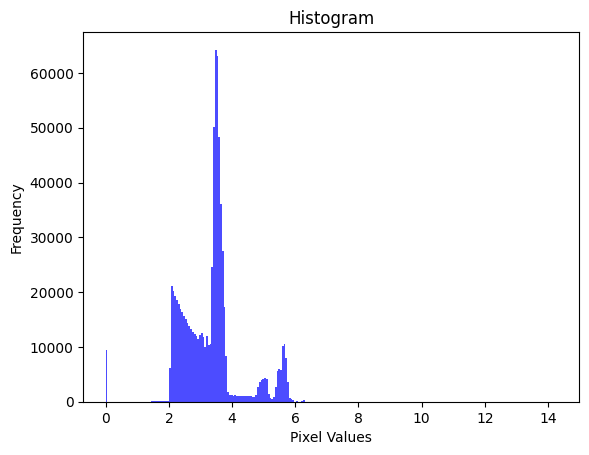

In [77]:
plot_histogram(groundtruth)